<a href="https://colab.research.google.com/github/Alfredo2212/ds-takehome/blob/main/notebooks/B_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import warnings
import shap

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score, RocCurveDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

In [206]:
# import dataset
url = "https://raw.githubusercontent.com/Alfredo2212/ds-takehome/main/data/credit_scoring.csv"
df = pd.read_csv(url)

In [172]:
df.head()

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
0,501000,41,13995609,5982664,0,624,0,0,-0.040
1,501001,58,13683833,3711198,0,809,0,0,0.001
2,501002,33,9417391,7172332,0,647,0,0,0.077
3,501003,45,6861811,8661056,0,450,0,0,0.038
4,501004,22,5640742,4520669,1,816,0,0,0.020


In [207]:
# Place leak cols into df_leak
leak_cols = ['leak_col_good','leak_col_subtle']
df_leak = df[leak_cols].copy()

# Drop Application ID & leak_cols from main dataframe
df = df.drop(columns=leak_cols + ['application_id'])


In [208]:
df_leak.head()

,leak_col_good,leak_col_subtle
0,0,-0.040
1,0,0.001
2,0,0.077
3,0,0.038
4,0,0.020


In [209]:
# Check null values for df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                6000 non-null   int64
 1   monthly_income     6000 non-null   int64
 2   loan_amount        6000 non-null   int64
 3   previous_defaults  6000 non-null   int64
 4   credit_score       6000 non-null   int64
 5   default            6000 non-null   int64
dtypes: int64(6)
memory usage: 281.4 KB


In [210]:
# Check duplicate valeus for df
df.duplicated().sum()

np.int64(0)

There is no null and duplicate values, dataset is ready for EDA.

In [211]:
# Check data distribution, skewness and descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,6000.0,4.032150e+01,1.130070e+01,21.0,31.00,41.0,50.00,59.0
monthly_income,6000.0,1.140386e+07,4.912598e+06,3000310.0,7163379.00,11299453.0,15737051.75,19986217.0
loan_amount,6000.0,8.001122e+06,4.071786e+06,1000794.0,4440939.00,7982303.5,11531445.00,14998580.0
previous_defaults,6000.0,2.436667e-01,4.847670e-01,0.0,0.00,0.0,0.00,3.0
credit_score,6000.0,5.759798e+02,1.583289e+02,300.0,438.75,577.5,713.00,849.0
default,6000.0,1.216667e-02,1.096387e-01,0.0,0.00,0.0,0.00,1.0


Descriptive statistics :
Age - limited age range ( 21 - 59 ), this suggests that individuals beyond this range are excluded from loan eligibility.
Monthly Income & Loan Amount - Very high variance in millions, skewed distributions.
Previous Defaults - Most values are 0, this informs imbalanced distribution.
Default : Dependent variable, with 1.2% default rate ( Mean 1.21 e-02 )

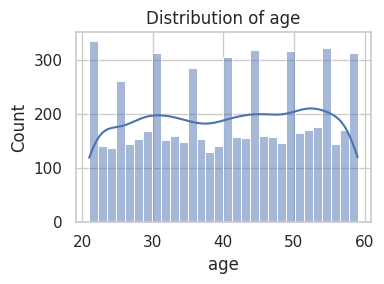

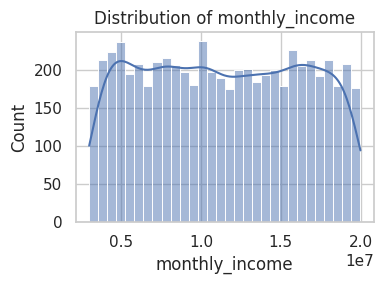

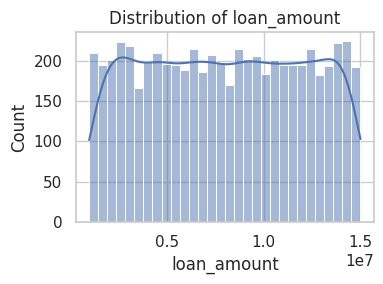

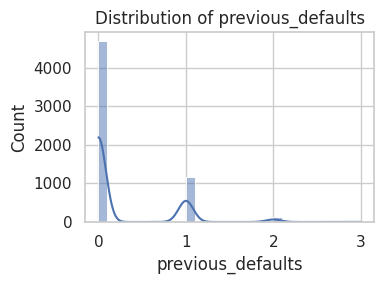

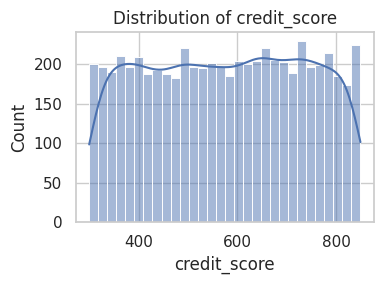

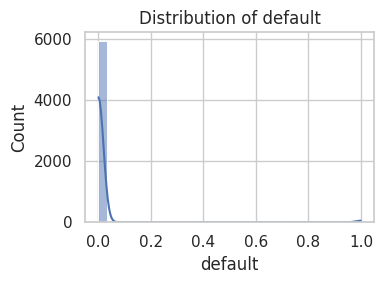

In [178]:
# Univariate Visualizations
num_cols = ['age','monthly_income','loan_amount','previous_defaults','credit_score','default']

# Histogram
for col in num_cols:
  plt.figure(figsize=(4,3))
  sns.histplot(df[col], kde=True, bins=30)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel('Count')
  plt.tight_layout()


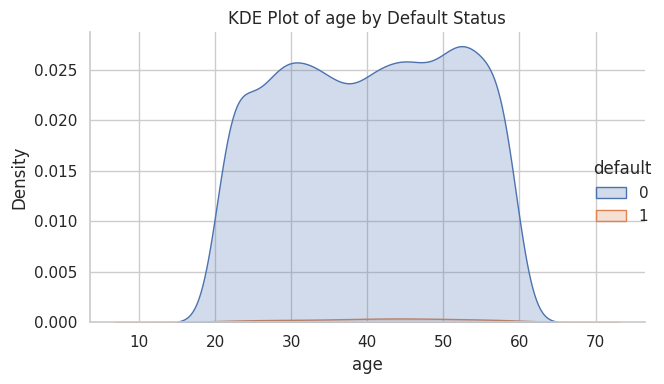

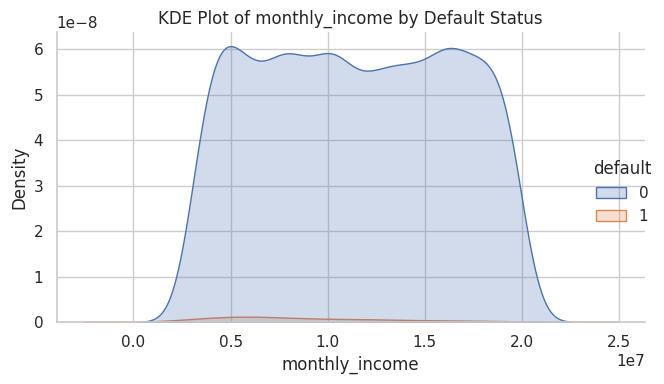

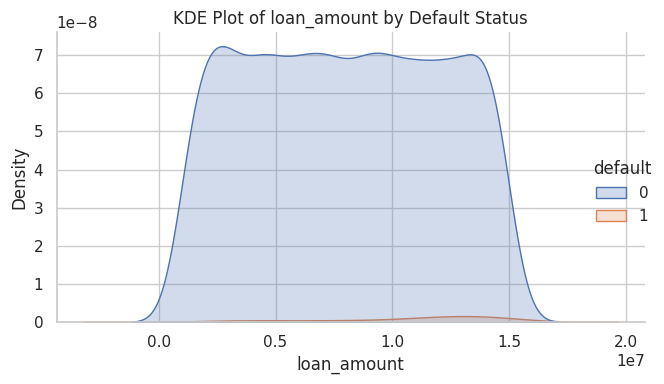

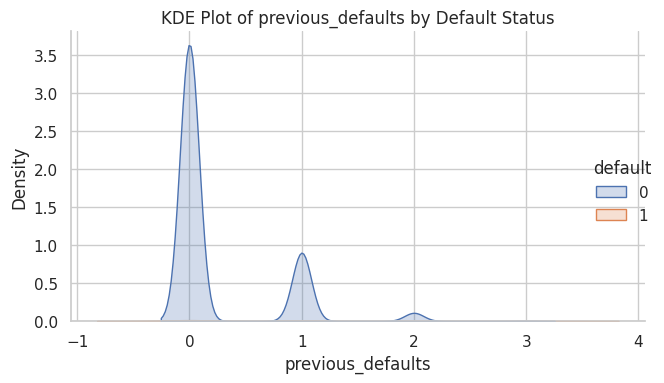

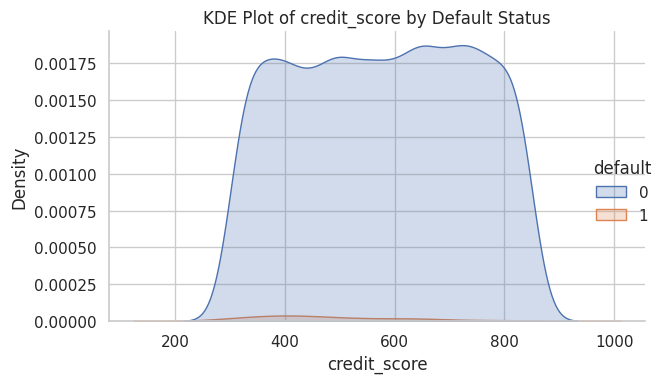

In [179]:
# Bivariate visualizations with Default (Y)
features = ['age','monthly_income','loan_amount','previous_defaults','credit_score']

for feature in features:
  sns.displot(data=df, x=feature, hue='default', kind='kde', fill=True, height=4, aspect=1.5)
  plt.title(f"KDE Plot of {feature} by Default Status")
  plt.xlabel(feature)
  plt.ylabel("Density")
  plt.tight_layout()

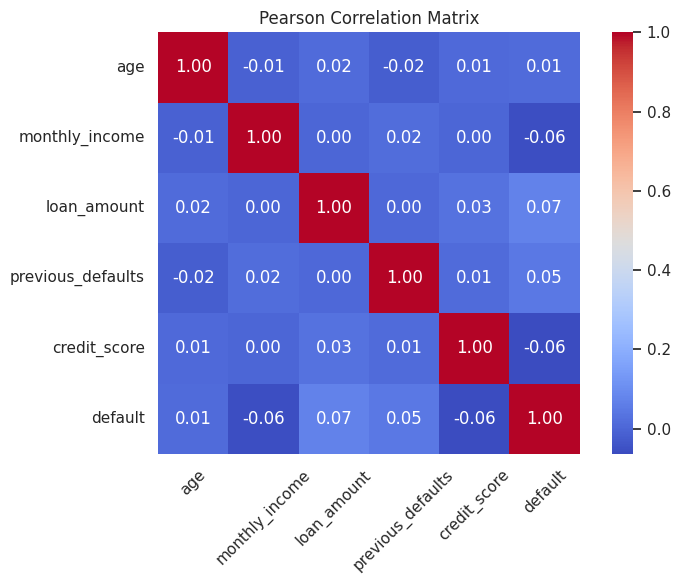

In [180]:
# Pearson correlation matrix
corr_matrix = df.corr(method='pearson')

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Pearson Correlation Matrix")
plt.xticks(rotation=45)
plt.tight_layout()

The correlation matrix reveals that these features have negligible linear relationships with default. It aligns with uniform distributions observed during EDA phase.

In [223]:
# Train test split & standardization function
def prepare_data(df, target='default', test_size=0.2, random_state=22):
    """
    Train test split and data standardization
    __________
    Parameter -
    df : dataframe
    __________
    Return -
    x scaled ( train & test ) , x test , y ( train & test )
    """
    x = df.drop(columns='default')
    y = df['default']

    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y # Ensure classes are balance
    )
    # Standardize
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled, x_test, y_train, y_test

x_train_scaled, x_test_scaled, x_test, y_train, y_test = prepare_data(df)

In [224]:
# Logistic regression model function
def run_logistic_regression(x_train, x_test, y_train, y_test):
    """
    model building - type Logistic Regression
    """
    model = LogisticRegression(random_state=22, max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    print("Logistic Regression :")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return model, y_pred

# Run base logit model for benchmark
logit_base, logit_base_preds = run_logistic_regression(x_train_scaled, x_test_scaled, y_train, y_test)

Logistic Regression :
[[1185    0]
 [  15    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200



Base Logistic Regression model fails to detect defaults because the dataset is highly imbalanced ( 1185 vs 15 ). Even though the overall accuracy is 99%.

In [225]:
# Utilizes XG BOOST for comparison
def run_xgboost(x_train, x_test, y_train, y_test):
    """
    model building - type XGBoost
    """
    model = XGBClassifier(random_state=22, max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    print("XGBoost :")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return model, y_pred

# Run base logit model for comparison
xgb_base, xgb_base_preds = run_xgboost(x_train_scaled, x_test_scaled, y_train, y_test)

XGBoost :
[[1184    1]
 [  15    0]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1185
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1200
   macro avg       0.49      0.50      0.50      1200
weighted avg       0.98      0.99      0.98      1200



XGBoost also fails to detect defaults, it is required to solve the imbalance problem firsthand

In [226]:
# Count number of defaults and non default case
df['default'].value_counts()

,count
default,
0,5927
1,73


In [227]:
# SMOTE to handle class imbalances
smote = SMOTE(random_state=22)
x_train_smote_scaled, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

print(y_train_smote.value_counts())

default
0    4742
1    4742
Name: count, dtype: int64


In [228]:
# Fitting Logit model with SMOTE oversampling technique
logit_smote, logit_smote_preds = run_logistic_regression(x_train_smote_scaled, x_test_scaled, y_train_smote, y_test)

Logistic Regression :
[[830 355]
 [  2  13]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      1185
           1       0.04      0.87      0.07        15

    accuracy                           0.70      1200
   macro avg       0.52      0.78      0.45      1200
weighted avg       0.99      0.70      0.81      1200



In [229]:
# Fitting XGB model with SMOTE oversampling technique
xgb_smote, xgb_smote_preds = run_xgboost(x_train_smote_scaled, x_test_scaled, y_train_smote, y_test)

XGBoost :
[[1149   36]
 [  12    3]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1185
           1       0.08      0.20      0.11        15

    accuracy                           0.96      1200
   macro avg       0.53      0.58      0.55      1200
weighted avg       0.98      0.96      0.97      1200



This model building will continue with variant of SMOTE technique and additional random forest classifier to predict better default cases.

In [230]:
# Implement Other SMOTE Technique
smote_tomek = SMOTETomek(random_state=22)
x_train_tomek_scaled, y_train_tomek = smote_tomek.fit_resample(x_train_scaled, y_train)
smote_adasyn = ADASYN(random_state=22)
x_train_adasyn_scaled, y_train_adasyn = smote_adasyn.fit_resample(x_train_scaled, y_train)

In [231]:
# Fitting Logit model with additionals SMOTE oversampling technique
# SMOTETOMEK
logit_tomek, logit_tomek_preds = run_logistic_regression(x_train_tomek_scaled, x_test_scaled, y_train_tomek, y_test)
# SMOTEADASYN
logit_adasyn, logit_adasyn_preds = run_logistic_regression(x_train_adasyn_scaled, x_test_scaled, y_train_adasyn, y_test)

# Fitting XGB model with additionals SMOTE oversampling technique
# SMOTETOMEK
xgb_tomek, xgb_tomek_preds = run_xgboost(x_train_tomek_scaled, x_test_scaled, y_train_tomek, y_test)
# SMOTEADASYN
xgb_adasyn, xgb_adasyn_preds = run_xgboost(x_train_adasyn_scaled, x_test_scaled, y_train_adasyn, y_test)

Logistic Regression :
[[830 355]
 [  2  13]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      1185
           1       0.04      0.87      0.07        15

    accuracy                           0.70      1200
   macro avg       0.52      0.78      0.45      1200
weighted avg       0.99      0.70      0.81      1200

Logistic Regression :
[[823 362]
 [  2  13]]
              precision    recall  f1-score   support

           0       1.00      0.69      0.82      1185
           1       0.03      0.87      0.07        15

    accuracy                           0.70      1200
   macro avg       0.52      0.78      0.44      1200
weighted avg       0.99      0.70      0.81      1200

XGBoost :
[[1151   34]
 [  12    3]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1185
           1       0.08      0.20      0.12        15

    accuracy                           0.96      1200
 

Call off other methods of oversampling since it doesnt increase precision-recall balance anymore

We'll use base Scaled - SMOTE - Logistic Regression as base since it yields best performance

In [232]:
# Adding Interaction Term
df_int = df.copy()
df_int["loan_income"] = df_int["loan_amount"] / (df_int["monthly_income"] + 1e-5) #capture debt burden
df_int["age_income"] = df_int["age"] * df_int["monthly_income"] #income growth
df_int["credit_loan"] = df_int["credit_score"] * df_int["loan_amount"] #risky pattern

In [233]:
# Train test split & standardization
x_int_train_scaled, x_int_test_scaled, x_inte_test, y_int_train, y_int_test = prepare_data(df_int)

# Apply SMOTE
smote = SMOTE(random_state=22)
x_int_train_smote, y_int_train_smote = smote.fit_resample(x_int_train_scaled, y_int_train)

This beats our logit model with smote technique in true negatives. from 814 to 830 correct predictions.

In [234]:
# Fitting Logit model with Interaction terms
logit_int, logit_int_pred = run_logistic_regression(x_int_train_smote, x_int_test_scaled, y_int_train_smote, y_int_test)

# Fitting XGB model with Interaction terms
xgb_int, xgb_int_pred = run_xgboost(x_int_train_smote, x_int_test_scaled, y_int_train_smote, y_int_test)

print("Random Forest :")
# Finally another non linear model ( Random Forest )
rf = RandomForestClassifier(random_state = 22, n_estimators= 100)

rf.fit(x_int_train_smote, y_int_train_smote)

y_int_pred_rf = rf.predict(x_int_test_scaled)

print(confusion_matrix(y_int_test, y_int_pred_rf))
print(classification_report(y_int_test, y_int_pred_rf))

Logistic Regression :
[[814 371]
 [  2  13]]
              precision    recall  f1-score   support

           0       1.00      0.69      0.81      1185
           1       0.03      0.87      0.07        15

    accuracy                           0.69      1200
   macro avg       0.52      0.78      0.44      1200
weighted avg       0.99      0.69      0.80      1200

XGBoost :
[[1141   44]
 [  12    3]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1185
           1       0.06      0.20      0.10        15

    accuracy                           0.95      1200
   macro avg       0.53      0.58      0.54      1200
weighted avg       0.98      0.95      0.97      1200

Random Forest :
[[1137   48]
 [  11    4]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1185
           1       0.08      0.27      0.12        15

    accuracy                           0.95      1200
   

Model Building Conclusion :

After several iterations of model experimentation and class imbalance handling, the returns diminish in performance improvements.

Selected Model for Hyperparameter Tuning ( Logistic Regression with SMOTE ) :

- Precision Class 1 Default : 0.04
- Recall Class 1 Default : 0.87
- F1-Score Class 1 Default : 0.07
- Overall Accuracy: 70%

Finally, the mode with high recall will be appropriate for identifying defaults, which aligns with the objective of minimizing false negatives in credit risk modeling.

In [193]:
# Ensemble Learning ( SMOTE only Logit and XGB )
ensemble_model = VotingClassifier(
    estimators = [
        ('logit', logit_smote),
        ('xgb', xgb_smote)
    ],
    voting="soft"
)

ensemble_model.fit(x_train_smote_scaled, y_train_smote)

VotingClassifier(estimators=[('logit',
                              LogisticRegression(max_iter=1000,
                                                 random_state=22)),
                             ('xgb',
                              LogisticRegression(max_iter=1000,
                                                 random_state=22))],
                 voting='soft')

In [235]:
# Make predictions using ensemble model
y_pred_ensemble = ensemble_model.predict(x_test_scaled)

print(confusion_matrix(y_test, y_pred_ensemble))
print(classification_report(y_test, y_pred_ensemble))

[[830 355]
 [  2  13]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82      1185
           1       0.04      0.87      0.07        15

    accuracy                           0.70      1200
   macro avg       0.52      0.78      0.45      1200
weighted avg       0.99      0.70      0.81      1200



In [236]:
# Hyperparameter tuning ensemble model for better result
class WeightedVotingClassifier(BaseEstimator, ClassifierMixin):
    """
    Ensemble logistic regression and XGBoost models, weighted soft voting.
    ___________
    Parameters -
    logit_weight : The weight assigned to the logit model.
    xgb_weight :  The weight assigned to the XGBoost model
    ___________
    Attributes -
    model : VotingClassifier
    """
    def __init__(self, logit_weight=1, xgb_weight=1):
        self.logit_weight = logit_weight
        self.xgb_weight = xgb_weight
        self.model = VotingClassifier(
            estimators = [
                ('logit', logit_smote),
                ('xgb', xgb_smote)
            ],
            voting ='soft',
            weights =[self.logit_weight, self.xgb_weight]
        )

    def fit(self,x,y):
        self.model.set_params(weights=[self.logit_weight, self.xgb_weight])
        self.model.fit(x,y)
        return self

    def predict(self, x):
        return self.model.predict(x)

    def predict_proba(self,x):
        return self.model.predict_proba(x)

In [240]:
# Grid search parameter
param_grid = {
    'logit_weight': [1.5, 1.6, 1.7],
    'xgb_weight': [0.9,0.95]
}

grid_search = GridSearchCV(
    estimator = WeightedVotingClassifier(),
    param_grid = param_grid,
    scoring = 'recall',
    cv = 5,
    n_jobs=-1
)

grid_search.fit(x_train_smote_scaled, y_train_smote)
print("Best Weights:", grid_search.best_params_)

# Best model
best_ensemble = grid_search.best_estimator_
y_pred_best = best_ensemble.predict(x_test_scaled)
print(confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Best Weights: {'logit_weight': 1.5, 'xgb_weight': 0.95}
[[1060  125]
 [   4   11]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1185
           1       0.08      0.73      0.15        15

    accuracy                           0.89      1200
   macro avg       0.54      0.81      0.54      1200
weighted avg       0.98      0.89      0.93      1200



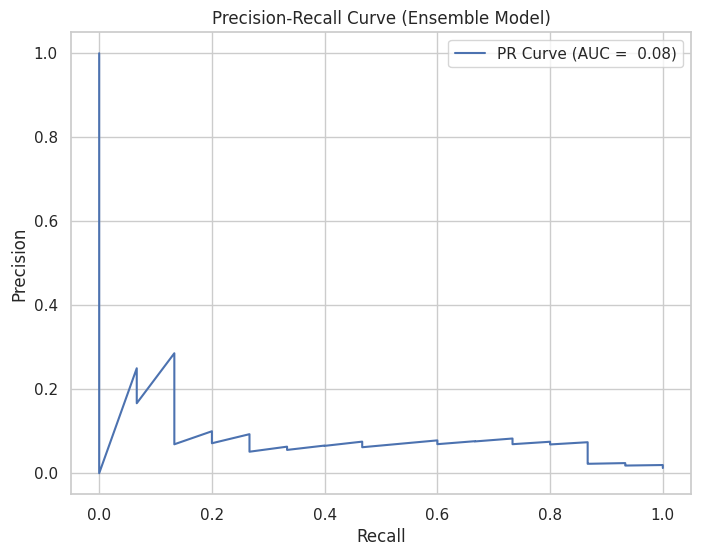

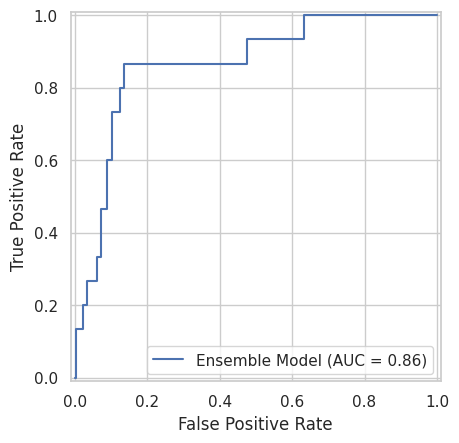

In [241]:
# Precision-Recall Curve for Imbalanced Dataset
# Predict probabilities for positive class ( Default )
def plot_model_curves(y_true, y_proba, model_name="Model"):
    """
    Plot Precision-Recall Curve and ROC Curve for classifier
    __________
    Parameters -
    y_true: array, binary labels 0/1
    y_proba: array, predicted probabilities for positive class
    model_name : str, label for name display in plot
    """
    # Precision Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall,precision)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot PR AUC
    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc: .2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot ROC AUC
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=model_name).plot()
    plt.grid(True)
    plt.show()

y_scores = best_ensemble.predict_proba(x_test_scaled)[:, 1]
plot_model_curves(y_test, y_scores, model_name="Ensemble Model")

-Evaluation Curves-

PR AUC (0.08) :

This shows the performance on rare class; it is adequate given the low prevalence with only 15 defaults in test dataset


ROC AUC (0.86) :

Strong model capability in distinguishing default vs non-default cases

Summary :

Although the ROC AUC shows excellent class separation (86%), the PR AUC reveals that the model struggles with precise identification of default cases — likely due to severe class imbalance and the rarity of defaults.

Business Insight :

- Priority 1 : High Recall - catching all potential defaulters
- Priority 2 : Precision among predicted defaulters

In [242]:
# Scorecard(probs) function ( FICO Scorecard )
def generate_scorecard(model, x, min_score=300, max_score=850):
    """
    Convert predicted probabilities into credit scorecard
    """
    # Predict probabilities for class 1 ( default )
    probs = model.predict_proba(x)[:, 1]
    scores = min_score + (1 - probs) * (max_score - min_score)

    return scores

In [250]:
x_test_with_score = x_test.copy()
x_test_with_score["scorecard_prob"] = generate_scorecard(best_ensemble, x_test_scaled)
x_test_with_score.sample(10)

,age,monthly_income,loan_amount,previous_defaults,credit_score,scorecard_prob
687,21,17236161,2710471,1,760,837.486868
2878,30,18676899,2406005,0,308,799.610211
323,39,6569325,1210495,0,451,750.124519
2451,58,17103728,10006458,0,372,695.032171
3437,59,5066158,1339295,0,781,822.557577
5242,32,6106969,1590344,0,696,817.235274
2757,24,19146480,4599659,0,834,845.668212
4598,39,14168408,13650014,0,403,570.298977
1956,55,8888750,11290362,0,541,542.625538
3413,58,19260854,14751068,1,314,570.173576


In [269]:
# SHAP Top-10 Feature Plot (PNG)
def plot_combined_weighted_shap(logit_model, xgb_model, x_test, weights=(1.5, 0.95), filename="Top10SHAP_Final.png"):
    """
    Creates a single SHAP plot combining both models'
    feature importances with weighted averaging.
    __________
    Parameters -
    logit_model : logit model used in ensemble model
    xgb_model : xgb model used in ensemble model
    x_test : test dataset features
    weights : weight implemented in ensemble model after GridSearch
    ______
    Return -
    File in content directory, single weighted averaging
    SHAP plot for ensemble model
    """
    # Get SHAP values for both models
    logit_explainer = shap.LinearExplainer(logit_model, x_test_scaled)
    xgb_explainer = shap.TreeExplainer(xgb_model)

    logit_shap = logit_explainer(x_test_scaled)
    xgb_shap = xgb_explainer(x_test_scaled)

    # Handle multi-class output
    if isinstance(logit_shap, list):
        logit_shap = logit_shap[1]
    if isinstance(xgb_shap, list):
        xgb_shap = xgb_shap[1]

    # Convert to DataFrame for easier manipulation
    logit_df = pd.DataFrame(logit_shap.values, columns=x_test.columns)
    xgb_df = pd.DataFrame(xgb_shap.values, columns=x_test.columns)

    # Calculate mean absolute SHAP values (feature importance)
    logit_importance = np.abs(logit_df).mean(axis=0)
    xgb_importance = np.abs(xgb_df).mean(axis=0)

    # Apply weights and normalize
    logit_weight, xgb_weight = weights
    total_weight = logit_weight + xgb_weight
    combined_importance = (logit_importance * logit_weight + xgb_importance * xgb_weight) / total_weight

    # Sort and select top 10
    top10 = combined_importance.sort_values(ascending=False).head(10)

    # Create plot
    plt.figure(figsize=(10, 6))
    y_pos = np.arange(len(top10))

    # Plot stacked bars
    plt.barh(y_pos, logit_importance[top10.index] * logit_weight / total_weight,
             color='#1f77b4', label='Logistic Regression')
    plt.barh(y_pos, xgb_importance[top10.index] * xgb_weight / total_weight,
             left=logit_importance[top10.index] * logit_weight / total_weight,
             color='#ff7f0e', label='XGBoost')

    # Add value labels
    for i, val in enumerate(combined_importance[top10.index]):
        plt.text(val + 0.01, i, f"{val:.2f}", va='center')

    # Fix y-axis labels
    plt.yticks(y_pos, top10.index)  # Match positions with labels
    plt.gca().invert_yaxis()  # Highest importance at top

    plt.title(f"Top-10 Weighted SHAP Features\n(Logit={logit_weight}, XGB={xgb_weight})")
    plt.xlabel("Weighted Mean Absolute SHAP Value")
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Usage with your optimal weights
plot_combined_weighted_shap(logit_smote, xgb_smote, x_test,
                          weights=(1.5, 0.95),
                          filename="Top10SHAP_Final.png")

In [255]:
# Default probability for IDR 5 Million
def get_default_probability(model, x, loan_amount_value, scaler=None):
    """
    Get default probability (class 1) for a given loan amount
    if none was found, fallback to the nearest neighbour of loan_amount
    __________
    Parameters-
    model: Trained model that supports predict_proba
    x_raw: Unscaled DataFrame with loan_amount column
    loan_amount_value: Loan amount
    scaler: Pre-fitted scaler
    _______
    Returns -
    A tuple with (row index, prob of default)
    """
    idx = (x["loan_amount"] - loan_amount_value).abs().idxmin()
    sample = x.loc[[idx]]

    if scaler:
        sample_scaled = scaler.transform(sample)
    else:
        sample_scaled = sample

    proba = model.predict_proba(sample_scaled)[0][1]
    return sample["loan_amount"].values[0], proba
loan_found, prob = get_default_probability(best_ensemble, x_test, 5000000, scaler=scaler)
print(f"Nearest loan amount: {loan_found}, Default Probability: {prob:.2f}")

Nearest loan amount: 4998435, Default Probability: 0.26
